In [ ]:
''' Datsest can be found here: https://www.kaggle.com/datasets/thedownhill/art-images-drawings-painting-sculpture-engraving/data '''

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import sklearn as sk
import pandas as pd
import torch
import random 
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.models import Model
from keras.models import load_model
from keras import backend as K
import joblib
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [2]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
torch.cuda.set_device(0)

1
NVIDIA GeForce RTX 2060


In [52]:
# Initialise directories and labels
patht = './dataset/training_set'
pathv = './dataset/validation_set'
categories = ['drawings', 'engraving', 'iconography', 'painting', 'sculpture']
img_size = 400

In [53]:
def load_and_resize_image(image_path, img_size):
    try:
        img_array = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img_array is None:
            raise ValueError(f"Image not found or cannot be read: {image_path}")
        return cv2.resize(img_array, (img_size, img_size))
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

In [54]:
def create_data(path, size, data_list):
    if not os.path.exists(path):
        raise ValueError(f"Path does not exist: {path}")
        
    for category in categories:
        category_path = os.path.join(path, category)
        if not os.path.exists(category_path):
            raise ValueError(f"Category path does not exist: {category_path}")
        
        class_num = categories.index(category)
        for img in os.listdir(category_path):
            img_path = os.path.join(category_path, img)
            if not img.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue  # Skip non-image files
            resized_image = load_and_resize_image(img_path, size)
            if resized_image is not None:
                data_list.append([resized_image, class_num])

training_data, validation_data = [], []

create_data(patht, img_size, training_data)
create_data(pathv, img_size, validation_data)

Error loading image ./dataset/training_set\engraving\249.jpg: Image not found or cannot be read: ./dataset/training_set\engraving\249.jpg
Error loading image ./dataset/training_set\engraving\304.jpg: Image not found or cannot be read: ./dataset/training_set\engraving\304.jpg
Error loading image ./dataset/training_set\engraving\356.jpg: Image not found or cannot be read: ./dataset/training_set\engraving\356.jpg
Error loading image ./dataset/training_set\iconography\331.jpg: Image not found or cannot be read: ./dataset/training_set\iconography\331.jpg
Error loading image ./dataset/training_set\iconography\69.jpg: Image not found or cannot be read: ./dataset/training_set\iconography\69.jpg
Error loading image ./dataset/training_set\painting\0000.jpg: Image not found or cannot be read: ./dataset/training_set\painting\0000.jpg
Error loading image ./dataset/training_set\painting\0025.jpg: Image not found or cannot be read: ./dataset/training_set\painting\0025.jpg
Error loading image ./datase

In [55]:
random.shuffle(training_data)
random.shuffle(validation_data)
print(len(training_data))
print(len(validation_data))

7721
856


In [58]:
train_x = np.array([features for features, label in training_data]).reshape(-1, img_size, img_size, 1)
train_y = np.array([label for features, label in training_data])
val_x = np.array([features for features, label in validation_data]).reshape(-1, img_size, img_size, 1)
val_y = np.array([label for features, label in validation_data])

train_x, val_x = train_x / 255.0, val_x / 255.0

train_y = to_categorical(train_y, num_classes=len(categories))
val_y = to_categorical(val_y, num_classes=len(categories))

In [60]:
os.environ["OMP_NUM_THREADS"] = '1'

In [6]:
train_x = np.load('train_x.npy')
train_y = np.load('train_y.npy')
val_x = np.load('val_x.npy')
val_y = np.load('val_y.npy')

In [7]:
train_x_flat = train_x.reshape(train_x.shape[0], -1)
val_x_flat = val_x.reshape(val_x.shape[0], -1)

In [13]:
input_dim = train_x_flat.shape[1]  # Flattened size of the input image
encoding_dim = 64  # Size of the encoded representation (can be adjusted)

# Input layer
input_layer = Input(shape=(input_dim,))

# Encoder
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)

# Decoder
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Encoder model for extracting features
encoder = Model(inputs=input_layer, outputs=encoded)

# Compile the autoencoder
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the autoencoder
autoencoder.fit(train_x_flat, train_x_flat,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(val_x_flat, val_x_flat))

# Use the encoder to get compressed representations
encoded_train_x = encoder.predict(train_x_flat)
encoded_val_x = encoder.predict(val_x_flat)

print("Encoded training data shape:", encoded_train_x.shape)
print("Encoded validation data shape:", encoded_val_x.shape)

Epoch 1/50
31/31 [==============================] - 34s 1s/step - loss: 0.0686 - val_loss: 0.0556
Epoch 2/50
31/31 [==============================] - 28s 919ms/step - loss: 0.0520 - val_loss: 0.0468
Epoch 3/50
31/31 [==============================] - 34s 1s/step - loss: 0.0441 - val_loss: 0.0439
Epoch 4/50
31/31 [==============================] - 73s 2s/step - loss: 0.0407 - val_loss: 0.0387
Epoch 5/50
31/31 [==============================] - 27s 887ms/step - loss: 0.0370 - val_loss: 0.0373
Epoch 6/50
31/31 [==============================] - 26s 841ms/step - loss: 0.0363 - val_loss: 0.0382
Epoch 7/50
31/31 [==============================] - 26s 850ms/step - loss: 0.0351 - val_loss: 0.0356
Epoch 8/50
31/31 [==============================] - 31s 998ms/step - loss: 0.0340 - val_loss: 0.0343
Epoch 9/50
31/31 [==============================] - 25s 808ms/step - loss: 0.0332 - val_loss: 0.0348
Epoch 10/50
31/31 [==============================] - 22s 722ms/step - loss: 0.0342 - val_loss: 0.034

In [86]:
np.save('train_x.npy', train_x)
np.save('train_y.npy', train_y)
np.save('val_x.npy', val_x)
np.save('val_y.npy', val_y)

In [73]:
def elbow_method(data):
    cluster_range = range(1, 11)  # Example: Testing from 1 to 10 clusters
    inertia_values = []
    silhouette_scores = []
    # Try different values of k (Elbow method)
    for k in cluster_range:
        model = MiniBatchKMeans(n_clusters = k, random_state = 42, batch_size = 100)
        model.fit(data)
        inertia_values.append(model.inertia_)

        if k > 1:
            score = silhouette_score(data, model.labels_)
            silhouette_scores.append(score)

    plt.figure(figsize=(10, 6))
    plt.plot(cluster_range, inertia_values, marker='o', color='blue', label='Inertia')
    plt.title('Elbow Method for Optimal k (MiniBatchKMeans)')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.xticks(cluster_range)
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Optional: Plot Silhouette Score for further evaluation
    plt.figure(figsize=(10, 6))
    plt.plot(cluster_range[1:], silhouette_scores, marker='o', color='green', label='Silhouette Score')
    plt.title('Silhouette Score for Different Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.xticks(cluster_range[1:])
    plt.grid(True)
    plt.legend()
    plt.show()

In [74]:
import warnings
warnings.filterwarnings('ignore')

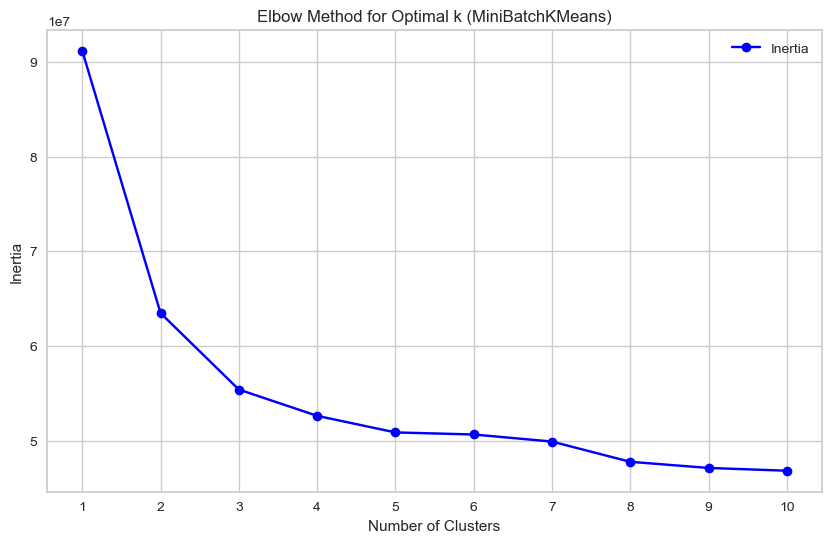

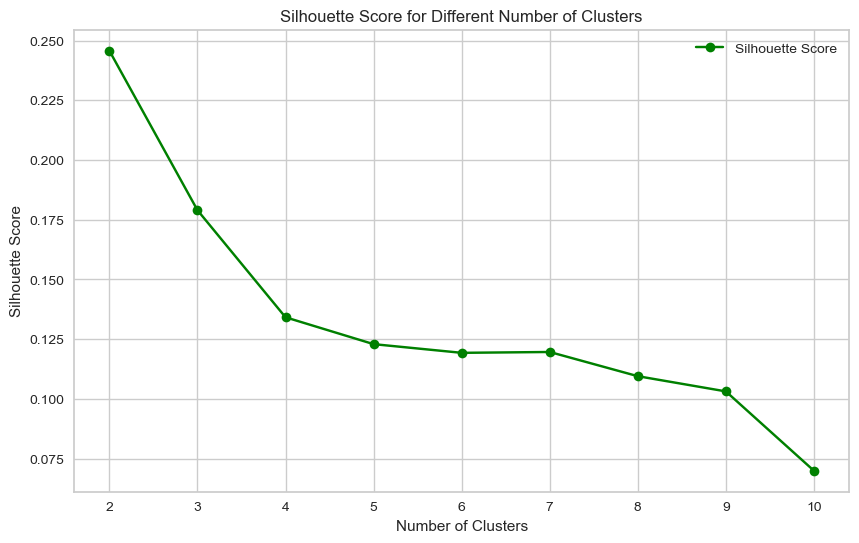

In [75]:
elbow_method(train_x_flat)

In [88]:
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')  # For multi-class classification
    ])
    return model

In [89]:
# Define the input shape and number of classes
input_shape = (img_size, img_size, 1)  # Grayscale images, so 1 channel
num_classes = len(categories)

# Create the CNN model
model = create_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [90]:
# Train the model with the prepared data
history = model.fit(train_x, train_y, 
                    epochs=10, 
                    batch_size=32, 
                    validation_data=(val_x, val_y))

Epoch 1/10
  8/242 [..............................] - ETA: 12:21 - loss: 4.5097 - accuracy: 0.2188

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000001DA465FC760>>
Traceback (most recent call last):
  File "C:\Users\ziads\anaconda3\envs\dl\lib\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_x, val_y)
print(f'Validation Accuracy: {val_acc * 100:.2f}%')

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()